# Remote sensing and modelling to assess crop-specific response to climate stressors
# CropClim Workshop, TUK, July 18, 2023
# Crop Type Classification using Sentinel-2 Satellite Data and Random Forest
Gohar Ghazaryan

This Jupyter Notebook demonstrates the process of classifying crop types using Sentinel-2 data and Random Forest algorithm. 

In this excersize, we aim to classify different crop types based on the Sentinel-2 imagery. Crop type classification can be a vital tool for various applications, such as agricultural monitoring, yield prediction, and land management.

## Dataset
The dataset used for this excersize consists of Sentinel-2 satellite images for 2019.  The images were clipped to the small area of interest and two indices (NDVI and NDMI) were calculated. 
The reference data is extracted from PlantVillage (2019) "PlantVillage Kenya Ground Reference Crop Type Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/RDNT.U41J87
The crop mas is based on ESA World Cover data (the masks includes irrigated, raifed and fallow land).
https://esa-worldcover.org/en


## Methodology
The classification process involves the following steps:

1. **Peprocess labled data**: This inclues creation of unique IDs based on crop type and rasterizing the lables

3. **Training Data Preparation**: The dataset will be divided into training and testing sets. The training set will be used to train the Random Forest classifier, while the testing set will be used to evaluate the model's performance.

4. **Model Training**: We will train a Random Forest classifier using the training dataset. The Random Forest algorithm is an ensemble learning method that combines multiple decision trees to make predictions.

5. **Model Evaluation**: The trained model will be evaluated using various evaluation metrics, such as accuracy, precision, recall, and F1-score. This evaluation will help us assess the model's performance and identify any potential issues.

6. **Crop Type Classification**: Finally, we will use the trained model to classify crop types in the Sentinel-2 imagery. 

## Tools and Libraries
We will use the following libraries:

- Scikit-learn: A popular machine learning library for implementing the Random Forest algorithm.
- NumPy: A fundamental package for scientific computing in Python.
- Matplotlib: A plotting library for visualizing data and results.
- Rasterio: A library for reading and writing geospatial raster datasets.
- Rioxarray: A library for working with geospatial raster data in the xarray data structure.
- Geopandas: A library for working with geospatial vector data.
- Pandas: A library for data manipulation and analysis.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from rasterio.plot import show
import rasterio
from rasterio.features import rasterize
import rioxarray

import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Directory of your images
dir_path = 'D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2'

# Filepaths for your images
image_paths = glob.glob(os.path.join(dir_path, 'Sentinel2_*.tif'))

# Create a list to hold the data from each image
datasets = []

# Open and append each image to the list
for fp in image_paths:
    with rasterio.open(fp) as src:
        datasets.append(xr.open_rasterio(src))
        print(f"Image Name: {fp}")  # Print the name of the image



Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_0.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_1.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_2.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_3.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_4.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_5.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_6.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_7.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_8.tif
Image Name: D:/05_Data/Kenya_cropClimTraining/raster/cropClim_data_v2\Sentinel2_2019_9.tif


C:\Users\ghazaryan\AppData\Local\Temp\ipykernel_12112\4179286905.py:13: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  datasets.append(xr.open_rasterio(src))


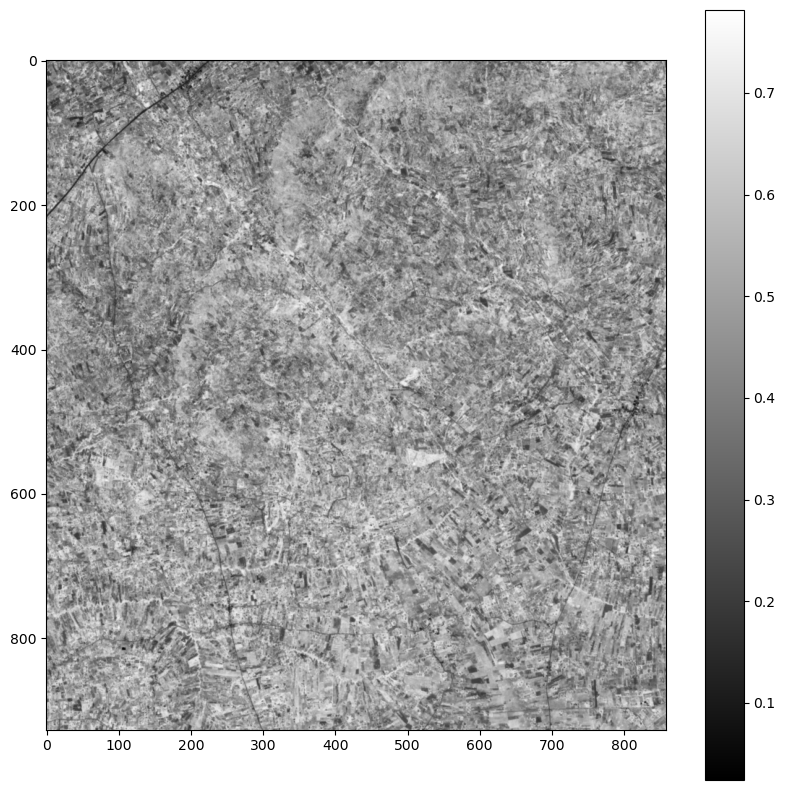

In [4]:
#Plot the first image (NDVI band)

plt.figure(figsize=(10, 10))
plt.imshow(datasets[0].sel(band=1) , cmap='gray')
plt.colorbar()
plt.show()

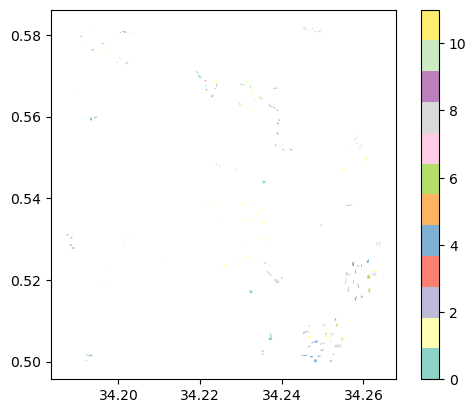

In [18]:
# Combine images along a new dimension
raster = xr.concat(datasets, dim='band')

# Read the shapefile
shp = gpd.read_file('D:/05_Data/Kenya_cropClimTraining/Final shapefiles/Training_polyons.shp')

# Create a unique integer for each type of crop
shp['Crop_ID'] = pd.factorize(shp['Crop_type'])[0]

shp.plot(column='Crop_ID', cmap='Set3', legend=True)
plt.show()

In [19]:
# Rasterize the shapefile to create the labels
labels = rasterio.features.rasterize(
    ((geom, value) for geom, value in zip(shp.geometry, shp.Crop_ID)),
    out_shape=(raster.rio.height, raster.rio.width),
    transform=raster.rio.transform(),
    fill=255,  # using 255 as a default value for missing data
    all_touched=True,
    dtype=np.uint16
)

# Flatten and reshape the raster
raster_2d = raster.values.reshape(raster.shape[0], -1).T

# Flatten the labels
labels_1d = labels.flatten()

# Remove pixels with NaN values
mask_nan = np.isnan(raster_2d).any(axis=1)

# Apply the NaN mask and the fill value mask
valid_mask = ~mask_nan & (labels_1d != 255)  # Modify the fill value accordingly

# Filter the raster and labels based on the combined mask
raster_2d_filtered = raster_2d[valid_mask]
labels_1d_filtered = labels_1d[valid_mask]

# Print the unique classes in labels_1d_filtered
unique_classes = np.unique(labels_1d_filtered)
print("Unique Classes:", unique_classes)

# Divide the data into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    raster_2d_filtered, labels_1d_filtered, test_size=0.2, random_state=42, stratify=labels_1d_filtered
)



Unique Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [20]:
# Create a Random Forest model
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Validate the model
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

# Predict labels for the entire raster
predicted_labels_full = clf.predict(raster_2d)

# Reshape the full array back into the original raster shape
predicted_labels_full = predicted_labels_full.reshape(labels.shape)

C:\Users\ghazaryan\.conda\envs\classEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghazaryan\.conda\envs\classEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghazaryan\.conda\envs\classEnv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.90      0.61      0.72       175
           1       0.67      0.93      0.78       431
           2       1.00      0.40      0.57        20
           3       1.00      0.25      0.40         8
           4       0.84      0.78      0.81       260
           5       0.00      0.00      0.00         2
           6       0.93      0.59      0.72        66
           7       0.00      0.00      0.00         4
           8       0.83      0.86      0.85       244
           9       0.93      0.59      0.72        71
          10       0.83      0.52      0.64        58
          11       0.00      0.00      0.00         4

    accuracy                           0.77      1343
   macro avg       0.66      0.46      0.52      1343
weighted avg       0.80      0.77      0.77      1343



In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_val, y_pred)

# Calculate the producer's accuracy
producer_accuracy = {}
for class_id in unique_classes:
    true_positive = confusion_mat[class_id, class_id]
    actual_count = np.sum(y_val == class_id)
    producer_accuracy[class_id] = true_positive / actual_count

# Calculate the user's accuracy
user_accuracy = {}
for class_id in unique_classes:
    true_positive = confusion_mat[class_id, class_id]
    predicted_count = np.sum(y_pred == class_id)
    user_accuracy[class_id] = true_positive / predicted_count

# Print the producer's and user's accuracy
print("Producer's Accuracy:")
for class_id, accuracy in producer_accuracy.items():
    print(f"Class {class_id}: {accuracy:.2f}")

print("\nUser's Accuracy:")
for class_id, accuracy in user_accuracy.items():
    print(f"Class {class_id}: {accuracy:.2f}")

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_val, y_pred)

# Print the overall accuracy
print("Overall Accuracy: {:.2f}".format(overall_accuracy))

Producer's Accuracy:
Class 0: 0.61
Class 1: 0.93
Class 2: 0.40
Class 3: 0.25
Class 4: 0.78
Class 5: 0.00
Class 6: 0.59
Class 7: 0.00
Class 8: 0.86
Class 9: 0.59
Class 10: 0.52
Class 11: 0.00

User's Accuracy:
Class 0: 0.90
Class 1: 0.67
Class 2: 1.00
Class 3: 1.00
Class 4: 0.84
Class 5: nan
Class 6: 0.93
Class 7: nan
Class 8: 0.83
Class 9: 0.93
Class 10: 0.83
Class 11: nan
Overall Accuracy: 0.77


C:\Users\ghazaryan\AppData\Local\Temp\ipykernel_16012\3870793829.py:19: RuntimeWarning: invalid value encountered in scalar divide
  user_accuracy[class_id] = true_positive / predicted_count


## Evaluation Metrics

During the validation of the classification model, several evaluation metrics are used to assess its performance. Here are the key evaluation metrics used in this project:

- **Producer's Accuracy**: Producer's accuracy, also known as the recall or the true positive rate, measures the proportion of correctly classified samples for each class. It indicates how well the model identifies samples belonging to a particular class out of all the actual samples in that class.

- **User's Accuracy**: User's accuracy, also known as the precision, measures the proportion of correctly classified samples for each class out of all the predicted samples for that class. It indicates how well the model performs in correctly predicting samples for a particular class out of all the predicted samples.

- **Overall Accuracy**: Overall accuracy measures the proportion of correctly classified samples out of the total number of samples. It provides an overall measure of the model's performance in correctly classifying the samples.



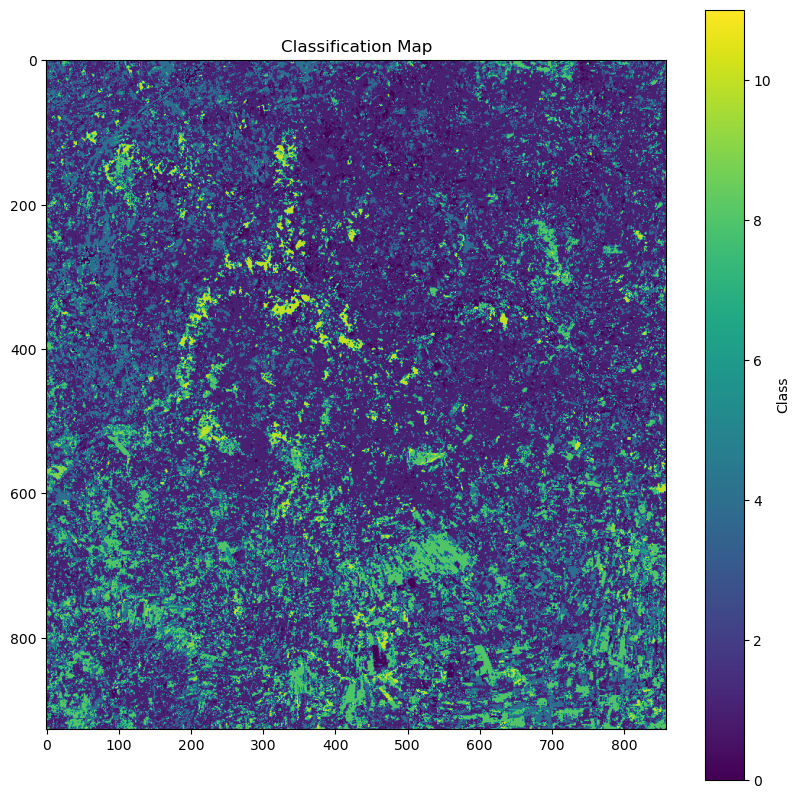

In [21]:

# Plot the classified map
plt.figure(figsize=(10, 10))
plt.imshow(predicted_labels_full, cmap='viridis', vmin=0, vmax=11)
plt.colorbar(label='Class')
plt.title('Classification Map')
plt.show()




C:\Users\ghazaryan\AppData\Local\Temp\ipykernel_16012\1177714388.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', len(unique_classes) + 1)


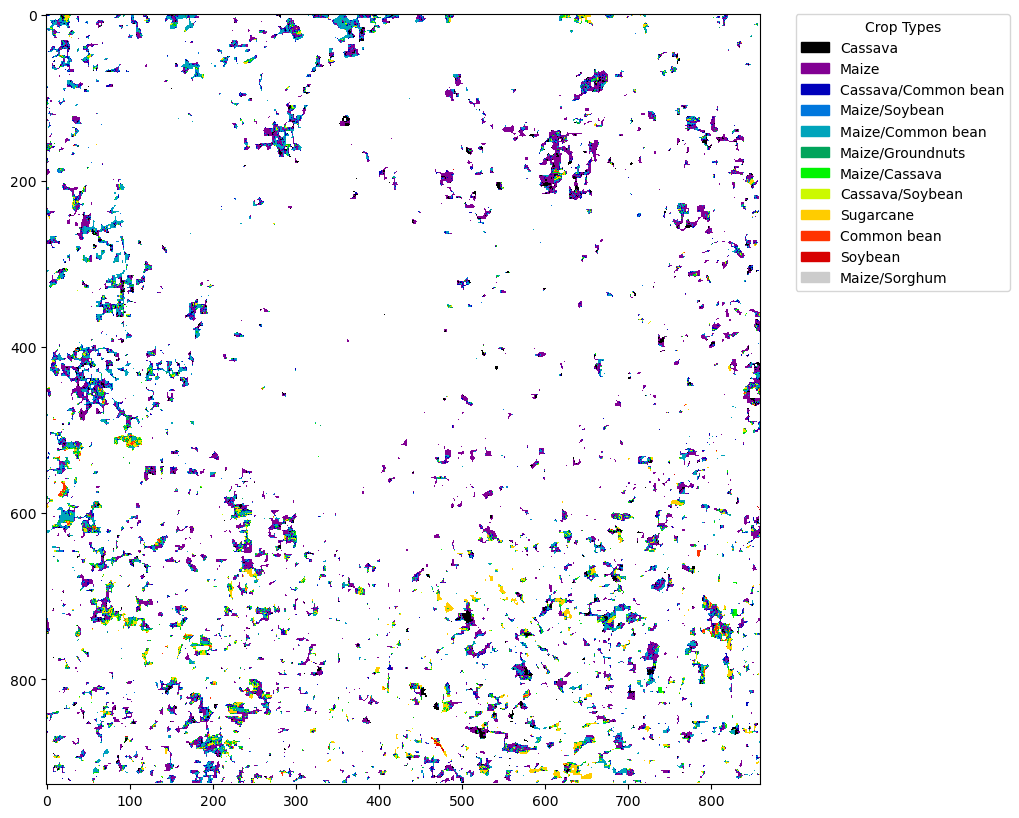

In [23]:


# Define missing data class
missing_data_class = 255

# Load the classified output (assumed to be stored in the variable 'predicted_labels_full')
# Replace the following line with code to load your classified output

# Get unique classes from the image excluding missing data
unique_classes = np.unique(predicted_labels_full[predicted_labels_full != missing_data_class]).astype(int)

# Create a mapping of class IDs to names
id_to_name = {row['Crop_ID']: row['Crop_type'] for _, row in shp.iterrows()}  # Replace 'shp' with your shapefile data

# Define color mapping - using 'nipy_spectral' colormap
cmap = plt.cm.get_cmap('nipy_spectral', len(unique_classes) + 1)

# Load the crop mask
crop_mask_path = 'D:/05_Data/Kenya_cropClimTraining/raster/croplandMask_WordCoverrepr3.tif'
with rasterio.open(crop_mask_path) as crop_mask_dataset:
    crop_mask_array = crop_mask_dataset.read(1)

# Apply the mask to the classified output
masked_predicted_labels = np.where(crop_mask_array == 1, predicted_labels_full, missing_data_class)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image, masking out the 'missing data' class
img = np.ma.masked_where(masked_predicted_labels == missing_data_class, masked_predicted_labels)
im = ax.imshow(img, cmap=cmap)

# Create a custom legend
labels = [id_to_name.get(uid, f'Unknown {uid}') for uid in unique_classes]  # map IDs to names, or label as Unknown
colors = [im.cmap(im.norm(class_id)) for class_id in unique_classes]

patches = [mpatches.Patch(color=colors[i], label=f"{label}") for i, label in enumerate(labels)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Crop Types')

plt.show()


In [24]:
# Create a new GeoTIFF file for the masked predicted labels
output_path = 'D:/05_Data/Kenya_cropClimTraining/raster/masked_predicted_labels.tif'

# Get the spatial information from the crop mask
with rasterio.open(crop_mask_path) as crop_mask_dataset:
    profile = crop_mask_dataset.profile

# Update the profile for the masked predicted labels
profile.update(count=1, dtype=rasterio.uint8)

# Write the masked predicted labels to the GeoTIFF file
with rasterio.open(output_path, 'w', **profile) as masked_predicted_labels_dataset:
    masked_predicted_labels_dataset.write(masked_predicted_labels.astype(rasterio.uint8), 1)

print("Masked predicted labels saved as GeoTIFF:", output_path)


Masked predicted labels saved as GeoTIFF: D:/05_Data/Kenya_cropClimTraining/raster/masked_predicted_labels.tif
